# Queue Estimation on LLMs

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
import re

In [3]:
data_dir = "data_03Dec"

In [4]:
def get_lam(C, w):
    """compute lambda in requests per second"""
    return float(C*1_000_000/w)
    
def get_fname_frag_for_exp(MB, C, w, t, n, d):
    """make name fragment for the CSV files of that experiment"""
    return f'MB_{MB}_C{C}_w{w}_t{t}_n{n}_d{d}'

def normalize(x):
    return (x - x.min()) / (x.max() - x.min())

def load_dfs(MB, C, w, t, n, d):
    exp_str = get_fname_frag_for_exp(MB, C, w, t, n, d)
    
    if C > 1:
        r_fnames = [f'{data_dir}/round_trips_{exp_str}_{i}.csv' for i in range(1, C+1)]
        print(f'Reading from {r_fnames}')        
        r_dfs = [pd.read_csv(r_fname, names=['i', 'start', 'end', 'rtt', 'ok']) for r_fname in r_fnames]
        r_df = pd.concat(r_dfs, ignore_index=True)
    else:
        r_fname = f'{data_dir}/round_trips_{exp_str}.csv'
        print(f'Reading from {r_fname}')
        r_df = pd.read_csv(r_fname, names=['i', 'start', 'end', 'rtt', 'ok'])
    r_df['start'] = pd.to_datetime(r_df['start'], unit="s")
    r_df['end'] = pd.to_datetime(r_df['end'], unit="s")
    first, last = r_df['start'].min(), r_df['start'].max() 
    interval = last - first
    start, end = first + 0.1 * interval, first + 0.9 * interval
    raw_r_df = pd.DataFrame(r_df)
    r_df = r_df.loc[(r_df['start'] >= start) & (r_df['start'] <= end)]

    q_fname = f'{data_dir}/queue_size_{exp_str}.csv'
    print(f'Reading from {q_fname}')
    q_df = pd.read_csv(q_fname, parse_dates=['timestamp'])
    q_df = q_df.loc[(q_df['timestamp'] >= start) & (q_df['timestamp'] <= end)]
    
    q_df.index = q_df['timestamp'] # normalize(q_df['timestamp'].astype(int))
    q_df['in_service'] = q_df.queue_size + q_df.batch_current_size
    return exp_str, q_df, r_df, raw_r_df

def extract_cq_df(r_df, start, end):
    starts = r_df.start.sort_values()
    ends = r_df.end.sort_values()
    cq = []
    for t in starts:
        cq.append([t, 1])
    for t in ends:
        cq.append([t, -1])
    cq = sorted(cq, key=lambda r: r[0])
    cq_df = pd.DataFrame(data=cq, columns=['time', 'd'])
    cq_df['q'] = cq_df['d'].cumsum()
    cq_df = cq_df.loc[(cq_df['time'] >= start) & (cq_df['time'] <= end)]
    cq_df.index = cq_df['time'] #normalize(cq_df['time'])
    return cq_df

def title_from_exp_str(frag):
    # Replace underscores with spaces
    s = frag.replace('_', ' ')
    
    # Insert '=' between letters and numbers
    s = re.sub(r'([a-zA-Z])(\d+)', r'\1=\2', s)
    
    # Add commas to large numbers (1,000 and above)
    s = re.sub(r'(\d{1,3})(?=(\d{3})+(?!\d))', r'\1,', s)
    return s


In [5]:
def plot_queues(q_df, cq_df, exp_str):
    mean_in_service = q_df['in_service'].mean()
    plt.figure(figsize=(10, 6))
    plt.plot(q_df.index, q_df['in_service'], label='In System')
    plt.plot(q_df.index, q_df['batch_current_size'], label='Current Batch')
    plt.plot(cq_df.index, cq_df['q'], label='From client side')
    plt.axhline(y=mean_in_service, color='green', linestyle='--', label=f'Mean ({mean_in_service:.2f})')
    
    plt.xlabel('Timestamp')
    plt.ylabel('Requests in Service')
    plt.title(title_from_exp_str(exp_str))
    ax = plt.gca()
    ax.set_ylim(0, int(q_df['in_service'].max()) + 1)
    ax.yaxis.set_major_locator(MaxNLocator(integer=True, prune='both', nbins=8))

    plt.legend()
    plt.tight_layout()

def plot_input_rate(q_df, lam, exp_str):
    mean_request_rate = q_df['request_rate'].mean()
    plt.figure(figsize=(10, 6))
    plt.plot(q_df.index, q_df['request_rate'], label=r'Observed Requests Rate $\lambda$')
    plt.axhline(y=mean_request_rate, color='green', linestyle='--', label=f'Mean ({mean_request_rate:.2f})')
    plt.axhline(y=lam, color='orange', linestyle=':', label=f'True value ({lam:.2f})')
    
    plt.xlabel('Timestamp')
    plt.ylabel(r'Observed Request Rate $\lambda$')
    plt.title(title_from_exp_str(exp_str))
    plt.legend()
    plt.tight_layout()

def plot_estimated_mu(mu_hat, r_df, exp_str):
    mean_mu_hat = mu_hat.mean()
    rtt_mean = r_df['rtt'].mean()
    per_req_mean = 1 / rtt_mean
    plt.figure(figsize=(10, 6))
    plt.plot(mu_hat, label=r'Estimated Service Rate $\hat{\mu}$')
    plt.axhline(y=mean_mu_hat, color='green', linestyle='--', label=f'Mean ({mean_mu_hat:.2f})')
    # plt.axhline(y=per_req_mean, color='orange', linestyle=':', label=f'Client Observed ({per_req_mean:.2f})')
    plt.ylim((0,None))
    plt.xlabel('Timestamp')
    plt.ylabel(r'Estimated Service Rate $\hat{\mu}$')
    plt.title(title_from_exp_str(exp_str))
    plt.legend()
    plt.tight_layout()


In [6]:
def estimate_mu(q_df, lam, d, MB):
    mu_hat = -1/d * q_df['in_service'].diff() + lam
    mu_hat = mu_hat.dropna()
    return mu_hat

# MB=1 $\lambda=0.5$

In [7]:
MB=1
C=1
w=2_000_000
t=800
n=110
d=2

In [8]:
lam = get_lam(C, w)

In [9]:
exp_str, q_df, r_df, raw_r_df = load_dfs(MB, C, w, t, n, d)

Reading from data_03Dec/round_trips_MB_1_C1_w2000000_t800_n110_d2.csv
Reading from data_03Dec/queue_size_MB_1_C1_w2000000_t800_n110_d2.csv
timestamp             datetime64[ns]
queue_size                   float64
batch_current_size           float64
request_rate                 float64
dtype: object


In [9]:
q_df.head()

,timestamp,queue_size,batch_current_size,request_rate,in_service
timestamp,,,,,
2024-12-03 21:06:36.892,2024-12-03 21:06:36.892,2.0,1.0,0.0,3.0
2024-12-03 21:06:38.901,2024-12-03 21:06:38.901,2.0,1.0,0.0,3.0
2024-12-03 21:06:40.909,2024-12-03 21:06:40.909,1.0,1.0,0.0,2.0
2024-12-03 21:06:42.916,2024-12-03 21:06:42.916,0.0,1.0,0.0,1.0
2024-12-03 21:06:44.925,2024-12-03 21:06:44.925,1.0,1.0,0.5,2.0


In [10]:
r_df.head()

,i,start,end,rtt,ok
10,10,2024-12-03 21:06:42.268282413,2024-12-03 21:06:46.426681995,4.158400,0
11,11,2024-12-03 21:06:42.455790758,2024-12-03 21:06:49.312729836,6.856939,0
12,12,2024-12-03 21:06:44.185692787,2024-12-03 21:06:50.777819633,6.592127,0
13,13,2024-12-03 21:06:45.321408510,2024-12-03 21:06:53.894768953,8.573361,0
14,14,2024-12-03 21:06:48.722270727,2024-12-03 21:06:55.713311911,6.991041,0


In [11]:
cq_df = extract_cq_df(raw_r_df, q_df['timestamp'].min(), q_df['timestamp'].max())

In [12]:
cq_df.head()

,time,d,q
time,,,
2024-12-03 21:06:38.300086498,2024-12-03 21:06:38.300086498,-1,2
2024-12-03 21:06:41.140037060,2024-12-03 21:06:41.140037060,-1,1
2024-12-03 21:06:42.268282413,2024-12-03 21:06:42.268282413,1,2
2024-12-03 21:06:42.455790758,2024-12-03 21:06:42.455790758,1,3
2024-12-03 21:06:43.783170462,2024-12-03 21:06:43.783170462,-1,2


In [13]:
mu_hat = estimate_mu(q_df, lam, d, MB)

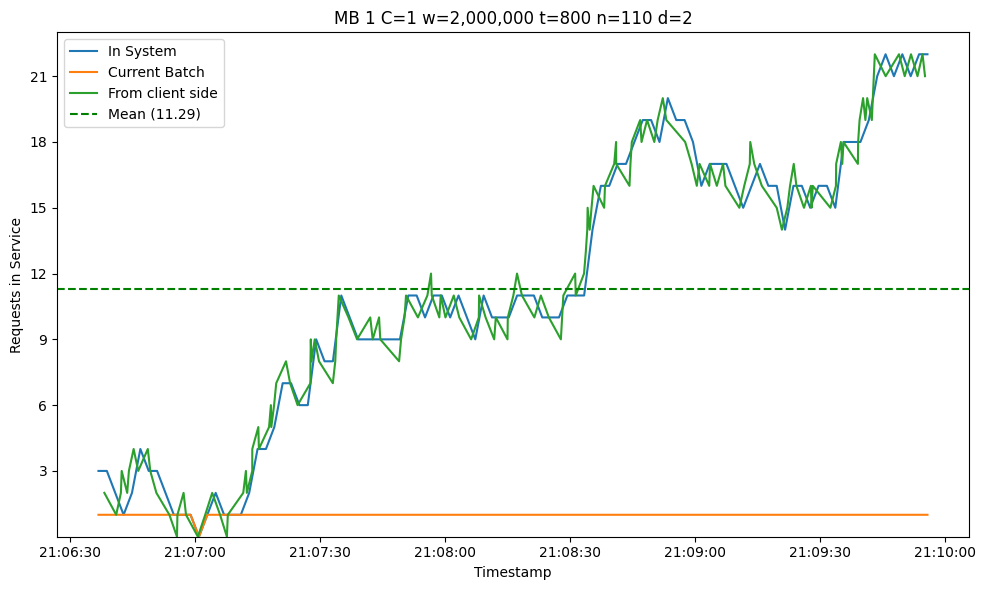

In [14]:
plot_queues(q_df, cq_df, exp_str)

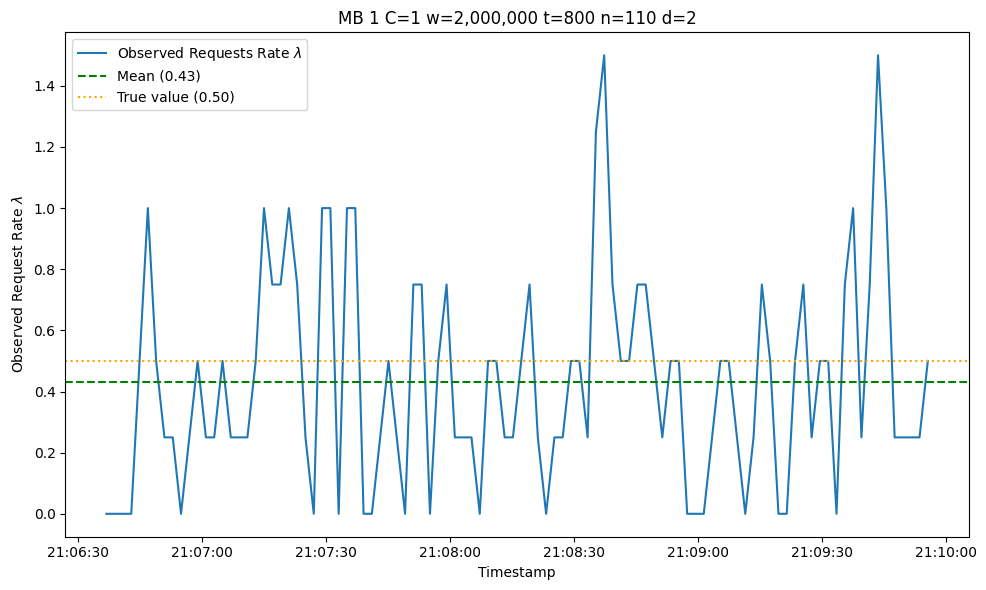

In [15]:
plot_input_rate(q_df, lam, exp_str)

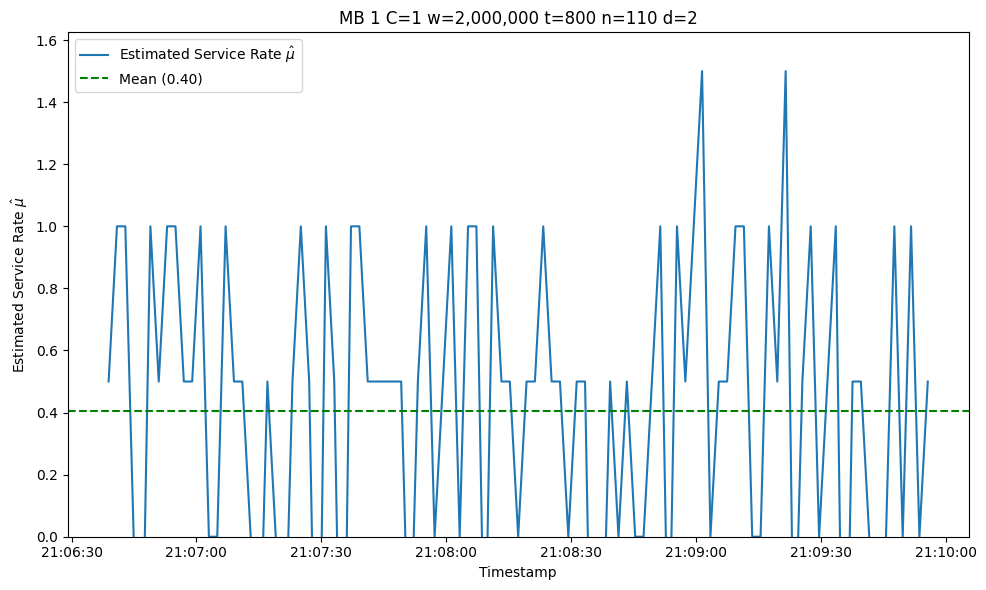

In [16]:
plot_estimated_mu(mu_hat, r_df, exp_str)

# MB=1 $\lambda=1.0$

In [17]:
MB=1
C=2
w=2_000_000
t=800
n=110
d=2

In [18]:
lam = get_lam(C, w)

In [19]:
exp_str, q_df, r_df, raw_r_df = load_dfs(MB, C, w, t, n, d)

Reading from ['data_03Dec/round_trips_MB_1_C2_w2000000_t800_n110_d2_1.csv', 'data_03Dec/round_trips_MB_1_C2_w2000000_t800_n110_d2_2.csv']
Reading from data_03Dec/queue_size_MB_1_C2_w2000000_t800_n110_d2.csv


In [20]:
q_df.head()

,timestamp,queue_size,batch_current_size,request_rate,in_service
timestamp,,,,,
2024-12-03 21:17:30.713,2024-12-03 21:17:30.713,18.0,1.0,1.5,19.0
2024-12-03 21:17:32.721,2024-12-03 21:17:32.721,20.0,1.0,1.5,21.0
2024-12-03 21:17:34.727,2024-12-03 21:17:34.727,21.0,1.0,1.0,22.0
2024-12-03 21:17:36.735,2024-12-03 21:17:36.735,22.0,1.0,1.0,23.0
2024-12-03 21:17:38.744,2024-12-03 21:17:38.744,21.0,1.0,0.5,22.0


In [21]:
r_df.head()

,i,start,end,rtt,ok
13,13,2024-12-03 21:17:31.673203707,2024-12-03 21:18:28.662525654,56.989322,0
14,14,2024-12-03 21:17:33.841029882,2024-12-03 21:18:36.509775400,62.668746,0
15,15,2024-12-03 21:17:34.577651024,2024-12-03 21:18:40.832197905,66.254547,0
16,16,2024-12-03 21:17:38.711394310,2024-12-03 21:18:46.910816431,68.199422,0
17,17,2024-12-03 21:17:39.028257132,2024-12-03 21:18:52.875875711,73.847618,0


In [22]:
cq_df = extract_cq_df(raw_r_df, q_df['timestamp'].min(), q_df['timestamp'].max())

In [23]:
cq_df.head()

,time,d,q
time,,,
2024-12-03 21:17:31.671000481,2024-12-03 21:17:31.671000481,1,20
2024-12-03 21:17:31.673203707,2024-12-03 21:17:31.673203707,1,21
2024-12-03 21:17:33.679883718,2024-12-03 21:17:33.679883718,-1,20
2024-12-03 21:17:33.837154627,2024-12-03 21:17:33.837154627,1,21
2024-12-03 21:17:33.841029882,2024-12-03 21:17:33.841029882,1,22


In [24]:
mu_hat = estimate_mu(q_df, lam, d, MB)

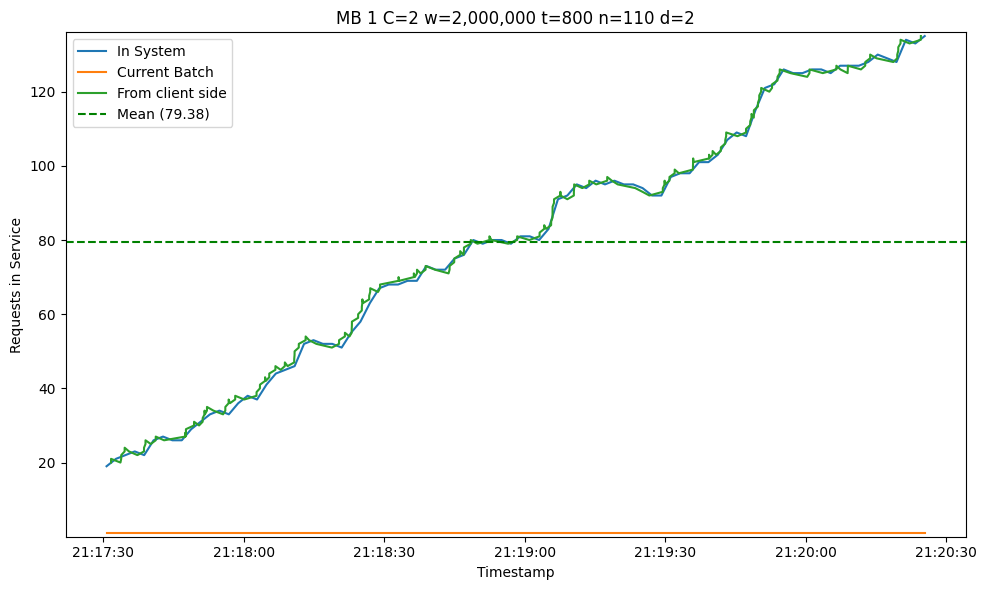

In [25]:
plot_queues(q_df, cq_df, exp_str)

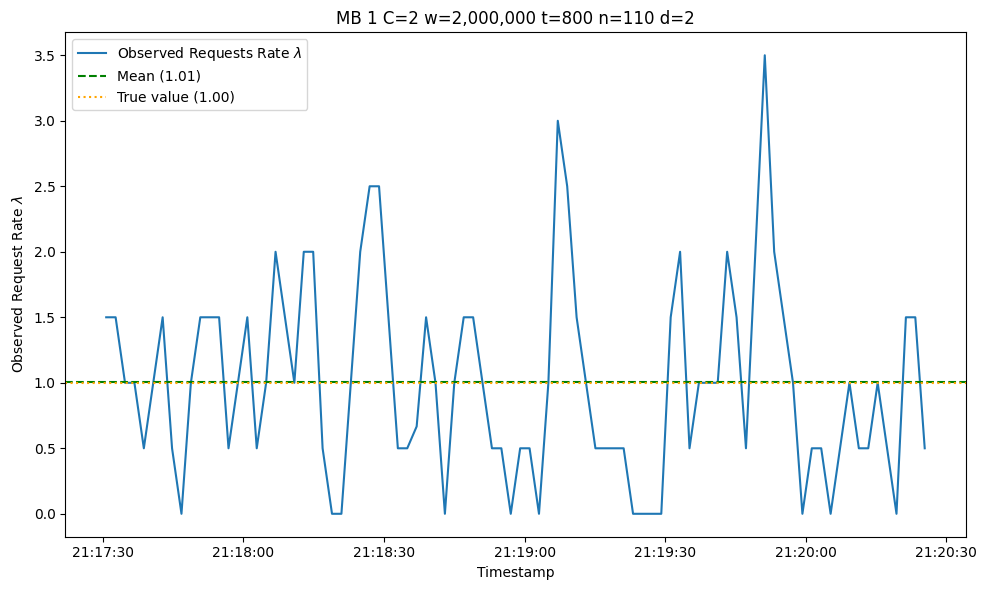

In [26]:
plot_input_rate(q_df, lam, exp_str)

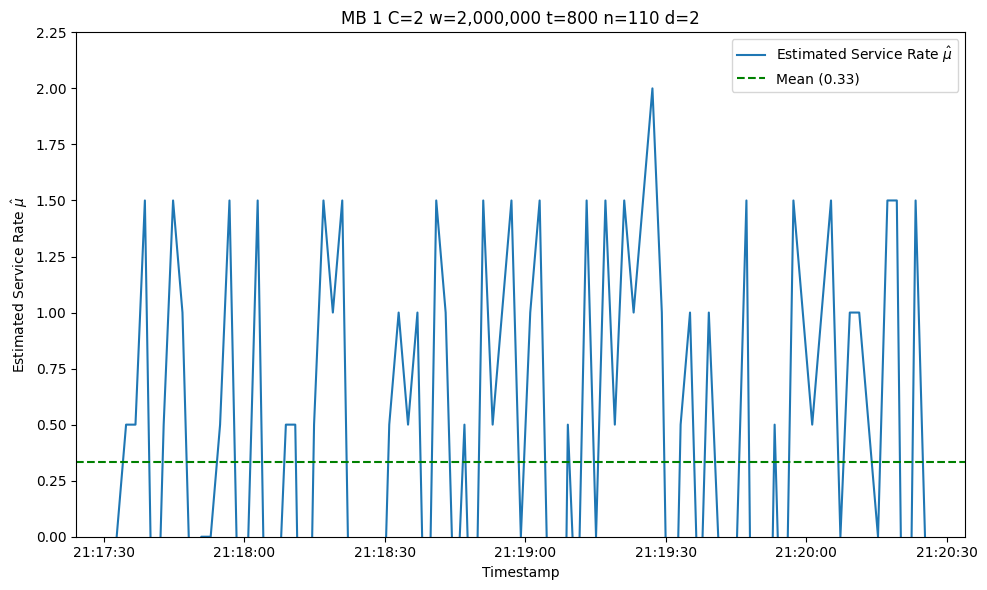

In [27]:
plot_estimated_mu(mu_hat, r_df, exp_str)

# MB=1 $\lambda=2.0$

In [28]:
MB=1
C=1
w=500_000
t=800
n=110
d=2

In [29]:
lam = get_lam(C, w)

In [30]:
exp_str, q_df, r_df, raw_r_df = load_dfs(MB, C, w, t, n, d)

Reading from data_03Dec/round_trips_MB_1_C1_w500000_t800_n110_d2.csv
Reading from data_03Dec/queue_size_MB_1_C1_w500000_t800_n110_d2.csv


In [31]:
q_df.head()

,timestamp,queue_size,batch_current_size,request_rate,in_service
timestamp,,,,,
2024-12-03 21:11:47.095,2024-12-03 21:11:47.095,18.0,1.0,2.75,19.0
2024-12-03 21:11:49.105,2024-12-03 21:11:49.105,26.0,1.0,2.75,27.0
2024-12-03 21:11:51.111,2024-12-03 21:11:51.111,35.0,1.0,4.50,36.0
2024-12-03 21:11:53.118,2024-12-03 21:11:53.118,35.0,1.0,2.50,36.0
2024-12-03 21:11:55.125,2024-12-03 21:11:55.125,37.0,1.0,0.75,38.0


In [32]:
r_df.head()

,i,start,end,rtt,ok
19,19,2024-12-03 21:11:45.606075287,2024-12-03 21:12:37.560954094,51.954879,0
20,20,2024-12-03 21:11:45.728679895,2024-12-03 21:12:39.028635979,53.299956,0
21,21,2024-12-03 21:11:47.042034388,2024-12-03 21:12:42.007757425,54.965723,0
22,22,2024-12-03 21:11:47.149442196,2024-12-03 21:12:43.475338459,56.325896,0
23,23,2024-12-03 21:11:47.204000473,2024-12-03 21:12:46.954142094,59.750141,0


In [33]:
cq_df = extract_cq_df(raw_r_df, q_df['timestamp'].min(), q_df['timestamp'].max())

In [34]:
cq_df.head()

,time,d,q
time,,,
2024-12-03 21:11:47.149442196,2024-12-03 21:11:47.149442196,1,21
2024-12-03 21:11:47.204000473,2024-12-03 21:11:47.204000473,1,22
2024-12-03 21:11:47.403752089,2024-12-03 21:11:47.403752089,1,23
2024-12-03 21:11:47.521586180,2024-12-03 21:11:47.521586180,1,24
2024-12-03 21:11:47.965533495,2024-12-03 21:11:47.965533495,1,25


In [35]:
mu_hat = estimate_mu(q_df, lam, d, MB)

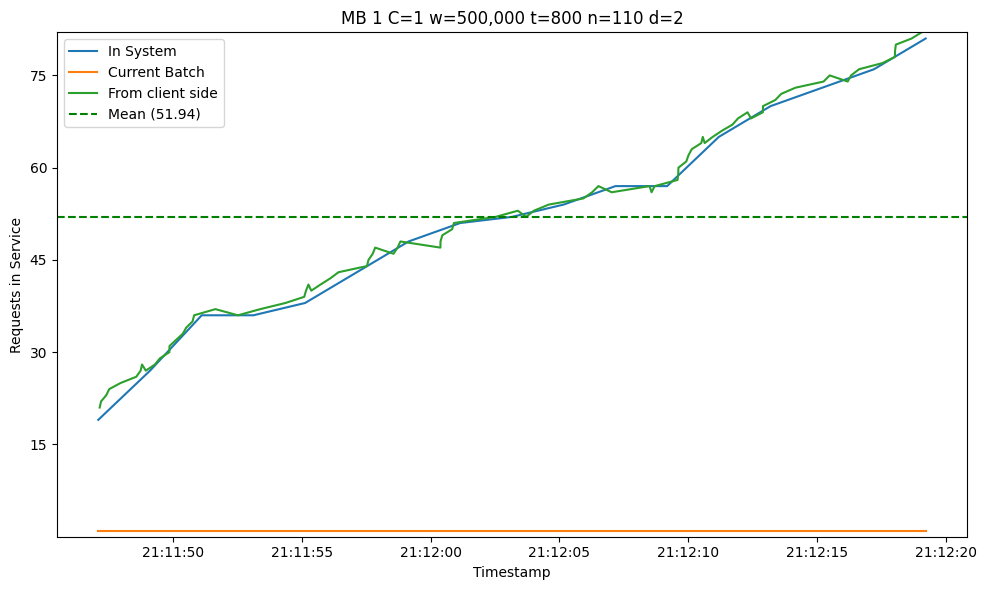

In [36]:
plot_queues(q_df, cq_df, exp_str)

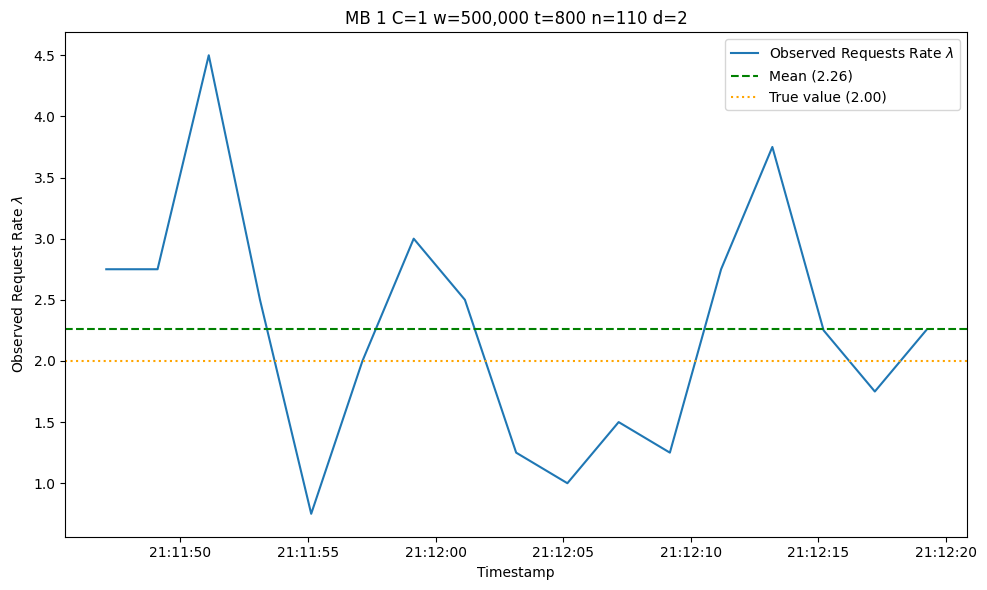

In [37]:
plot_input_rate(q_df, lam, exp_str)

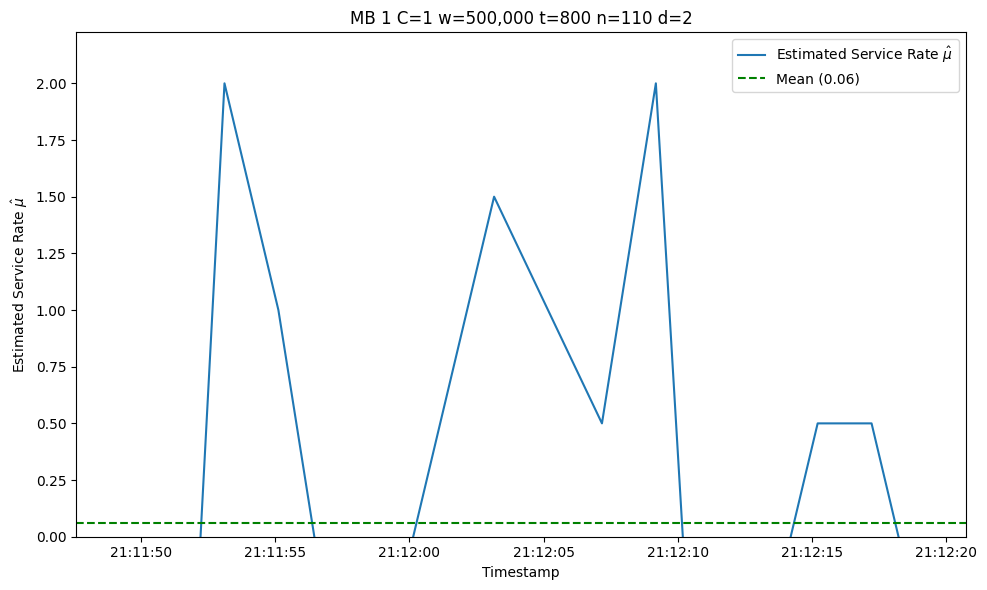

In [38]:
plot_estimated_mu(mu_hat, r_df, exp_str)

# MB=1 $\lambda=4.0$

In [39]:
MB=1
C=2
w=500_000
t=800
n=110
d=2

In [40]:
lam = get_lam(C, w)

In [41]:
exp_str, q_df, r_df, raw_r_df = load_dfs(MB, C, w, t, n, d)

Reading from ['data_03Dec/round_trips_MB_1_C2_w500000_t800_n110_d2_1.csv', 'data_03Dec/round_trips_MB_1_C2_w500000_t800_n110_d2_2.csv']
Reading from data_03Dec/queue_size_MB_1_C2_w500000_t800_n110_d2.csv


In [42]:
q_df.head()

,timestamp,queue_size,batch_current_size,request_rate,in_service
timestamp,,,,,
2024-12-03 21:28:05.594,2024-12-03 21:28:05.594,27.0,1.0,4.0,28.0
2024-12-03 21:28:07.602,2024-12-03 21:28:07.602,29.0,1.0,1.5,30.0
2024-12-03 21:28:09.609,2024-12-03 21:28:09.609,42.0,1.0,4.0,43.0
2024-12-03 21:28:11.616,2024-12-03 21:28:11.616,47.0,1.0,5.0,48.0
2024-12-03 21:28:13.624,2024-12-03 21:28:13.624,55.0,1.0,3.5,56.0


In [43]:
r_df.head()

,i,start,end,rtt,ok
16,16,2024-12-03 21:28:07.386181831,2024-12-03 21:29:31.636446476,84.250265,0
17,17,2024-12-03 21:28:07.898325205,2024-12-03 21:29:39.108553648,91.210228,0
18,18,2024-12-03 21:28:07.938955545,2024-12-03 21:29:44.255033255,96.316078,0
19,19,2024-12-03 21:28:08.073643923,2024-12-03 21:29:50.656018496,102.582374,0
20,20,2024-12-03 21:28:08.513355255,2024-12-03 21:29:56.202515125,107.689160,0


In [44]:
cq_df = extract_cq_df(raw_r_df, q_df['timestamp'].min(), q_df['timestamp'].max())

In [45]:
cq_df.head()

,time,d,q
time,,,
2024-12-03 21:28:07.386181831,2024-12-03 21:28:07.386181831,1,31
2024-12-03 21:28:07.388311625,2024-12-03 21:28:07.388311625,1,32
2024-12-03 21:28:07.898325205,2024-12-03 21:28:07.898325205,1,33
2024-12-03 21:28:07.900598288,2024-12-03 21:28:07.900598288,1,34
2024-12-03 21:28:07.938955545,2024-12-03 21:28:07.938955545,1,35


In [46]:
mu_hat = estimate_mu(q_df, lam, MB)

TypeError: estimate_mu() missing 1 required positional argument: 'MB'

In [ ]:
plot_queues(q_df, cq_df, exp_str)

In [ ]:
plot_input_rate(q_df, lam, exp_str)

In [ ]:
plot_estimated_mu(mu_hat, r_df, exp_str)